## Human Activity Recognition Using Accelerometer and CNN

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [2]:
print(tf.__version__)

2.0.0


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

## Load Dataset

In [5]:
# Reading like this gives error because our original data is not properly formatted.
# Link to dataset - https://www.cis.fordham.edu/wisdm/dataset.php
pd.read_csv("data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt")

ParserError: Error tokenizing data. C error: Expected 6 fields in line 134634, saw 11


In [11]:
# Some lines have multiple lines clubbed together as shown below
# 13,Downstairs,3498732310000,5.13,10.42,4.671779;15,Jogging,328982249000,5.37,-3.36,7.3141265;
# We need to process such lines to avoid above error.
# Reading file line by line

file = open("data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt")
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(",") # Split by ","
        last = line[5].split(";")[0] # After 6th element split by ";" as we have ";" in our data shown above
        last = last.strip() # Remove white space
        if last == "":
            break;
        
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
          print("Error at line number:", i)

Error at line number: 281873
Error at line number: 281874
Error at line number: 281875


In [12]:
processedList

[['33', 'Jogging', '49105962326000', '-0.6946377', '12.680544', '0.50395286'],
 ['33', 'Jogging', '49106062271000', '5.012288', '11.264028', '0.95342433'],
 ['33', 'Jogging', '49106112167000', '4.903325', '10.882658', '-0.08172209'],
 ['33', 'Jogging', '49106222305000', '-0.61291564', '18.496431', '3.0237172'],
 ['33', 'Jogging', '49106332290000', '-1.1849703', '12.108489', '7.205164'],
 ['33', 'Jogging', '49106442306000', '1.3756552', '-2.4925237', '-6.510526'],
 ['33', 'Jogging', '49106542312000', '-0.61291564', '10.56939', '5.706926'],
 ['33', 'Jogging', '49106652389000', '-0.50395286', '13.947236', '7.0553403'],
 ['33', 'Jogging', '49106762313000', '-8.430995', '11.413852', '5.134871'],
 ['33', 'Jogging', '49106872299000', '0.95342433', '1.3756552', '1.6480621'],
 ['33', 'Jogging', '49106982315000', '-8.19945', '19.57244', '2.7240696'],
 ['33', 'Jogging', '49107092330000', '1.4165162', '5.7886477', '2.982856'],
 ['33', 'Jogging', '49107202316000', '-1.879608', '-2.982856', '-0.2996

In [13]:
columns = ["user", "activity", "time", "x", "y", "z"]

In [14]:
data = pd.DataFrame(data = processedList, columns=columns)
data.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [16]:
data.shape

(343416, 6)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user      343416 non-null  object
 1   activity  343416 non-null  object
 2   time      343416 non-null  object
 3   x         343416 non-null  object
 4   y         343416 non-null  object
 5   z         343416 non-null  object
dtypes: object(6)
memory usage: 15.7+ MB


In [18]:
# Checking Null Values
data.isnull().sum()

user        0
activity    0
time        0
x           0
y           0
z           0
dtype: int64

In [19]:
# As we can see the data is very unballanced. We need to balance the data so the maodel is accurate.
data["activity"].value_counts()

Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: activity, dtype: int64

## Balance the data

In [20]:
data["x"] = data["x"].astype("float")
data["y"] = data["y"].astype("float")
data["z"] = data["z"].astype("float")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user      343416 non-null  object 
 1   activity  343416 non-null  object 
 2   time      343416 non-null  object 
 3   x         343416 non-null  float64
 4   y         343416 non-null  float64
 5   z         343416 non-null  float64
dtypes: float64(3), object(3)
memory usage: 15.7+ MB


In [21]:
Fs = 20

In [22]:
# Plotting some of the data for each activity
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data["time"], data["x"], "X-Axis")
    plot_axis(ax1, data["time"], data["y"], "Y-Axis")
    plot_axis(ax2, data["time"], data["z"], "Z-Axis")
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
def plot_axis(ax, x, y, title):
    ax.plot(x, y, "g")
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

In [25]:
activities = data["activity"].value_counts().index
activities

Index(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'], dtype='object')

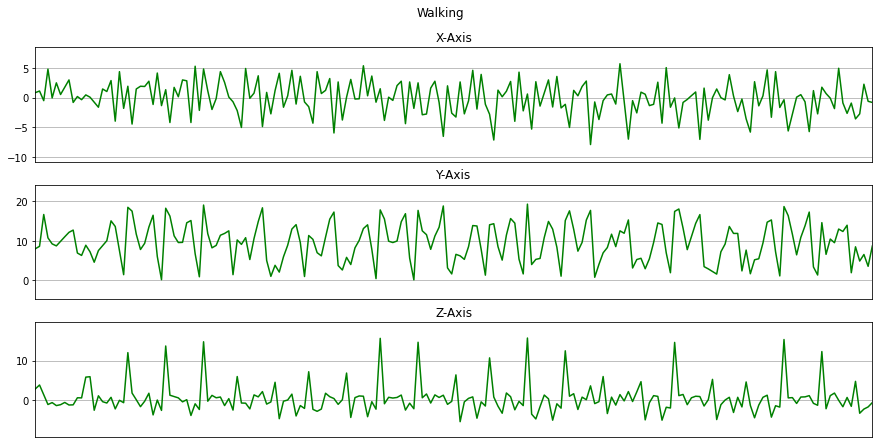

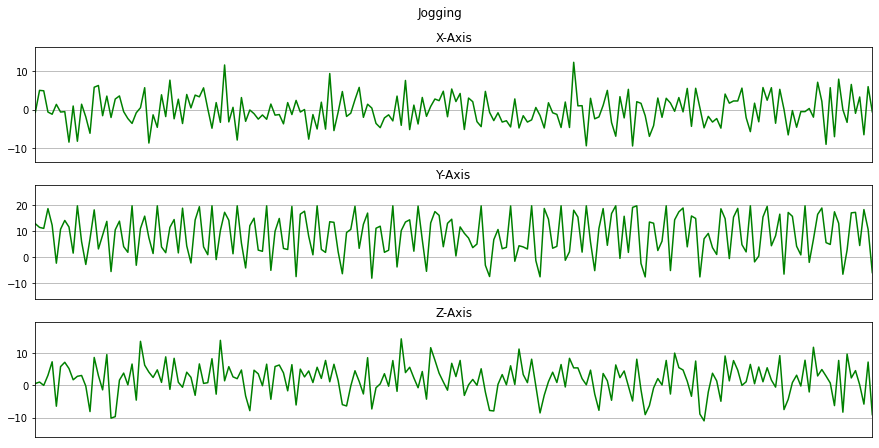

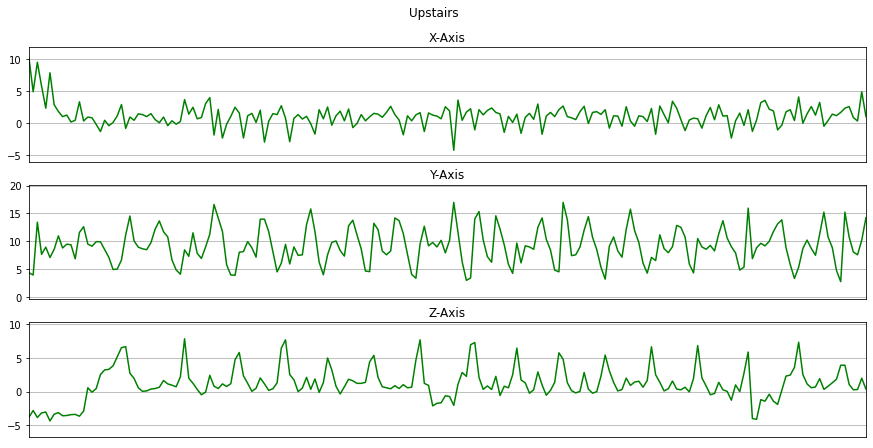

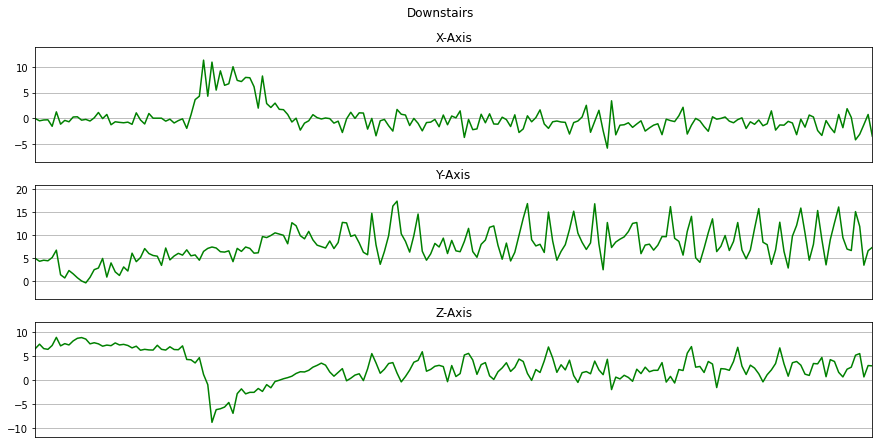

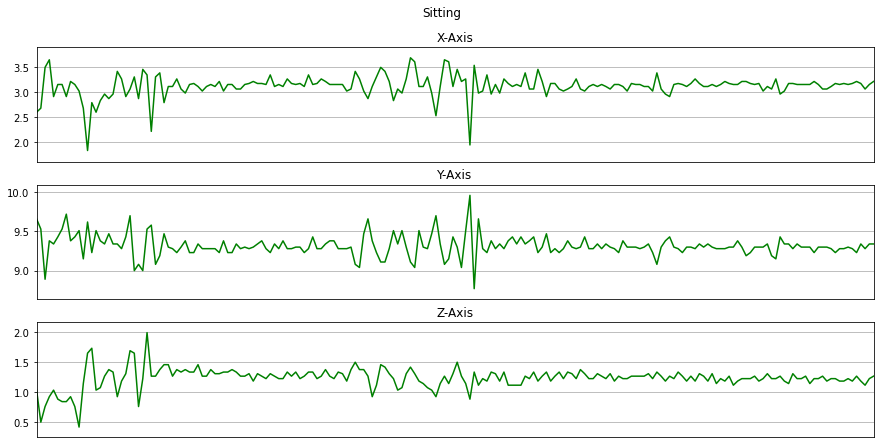

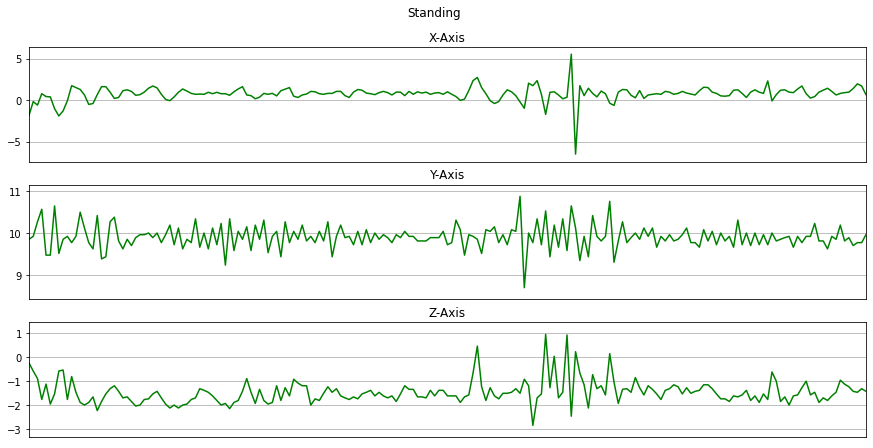

In [24]:
for activity in activities:
    data_for_plot = data[(data["activity"] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

In [26]:
# Dropping unnecessary columns
df = data.drop(["user", "time"], axis=1).copy()
df.head()

,activity,x,y,z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


In [27]:
df["activity"].value_counts()

Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: activity, dtype: int64

In [28]:
# To balance the dataset only taking 3555 of each activities.
Walking = df[df["activity"] == "Walking"].head(3555).copy()
Jogging = df[df["activity"] == "Jogging"].head(3555).copy()
Upstairs = df[df["activity"] == "Upstairs"].head(3555).copy()
Downstairs = df[df["activity"] == "Downstairs"].head(3555).copy()
Sitting = df[df["activity"] == "Sitting"].head(3555).copy()
Standing = df[df["activity"] == "Standing"].head(3555).copy()

In [29]:
# Joining all the data now
balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
balanced_data.shape

(21330, 4)

In [30]:
# Now we have our balanced dataset
balanced_data["activity"].value_counts()

Standing      3555
Jogging       3555
Walking       3555
Sitting       3555
Downstairs    3555
Upstairs      3555
Name: activity, dtype: int64

In [31]:
balanced_data.head()

,activity,x,y,z
597,Walking,0.844462,8.008764,2.792171
598,Walking,1.116869,8.621680,3.786457
599,Walking,-0.503953,16.657684,1.307553
600,Walking,4.794363,10.760075,-1.184970
601,Walking,-0.040861,9.234595,-0.694638


In [32]:
# Now activities are string values. we need to convert it to numbers.
from sklearn.preprocessing import LabelEncoder

In [33]:
label = LabelEncoder()
balanced_data["label"] = label.fit_transform(balanced_data["activity"])
balanced_data.head()

,activity,x,y,z,label
597,Walking,0.844462,8.008764,2.792171,5
598,Walking,1.116869,8.621680,3.786457,5
599,Walking,-0.503953,16.657684,1.307553,5
600,Walking,4.794363,10.760075,-1.184970,5
601,Walking,-0.040861,9.234595,-0.694638,5


In [34]:
label.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

## Data Standardization

##### Standardizing our data to bring down the variance.

In [35]:
x = balanced_data[["x", "y", "z"]]
y = balanced_data["label"]

In [36]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

scaled_x = pd.DataFrame(data=x, columns=["x", "y", "z"])
scaled_x["label"] = y.values
scaled_x

,x,y,z,label
0,0.000503,-0.099190,0.337933,5
1,0.073590,0.020386,0.633446,5
2,-0.361275,1.588160,-0.103312,5
3,1.060258,0.437573,-0.844119,5
4,-0.237028,0.139962,-0.698386,5
...,...,...,...,...
21325,-0.470217,0.178084,0.261019,3
21326,-0.542658,0.193692,0.248875,3
21327,-0.628514,0.197593,0.261019,3
21328,-0.781444,0.049322,0.155768,3


## Frame Preperation

In [37]:
import scipy.stats as stats

In [38]:
# Since our data has time in seconds and a very few seconds timeline. 
# We are only capturing the most performed activity for every 4 seconds. 
# i.e., capture the activities done in every 4 seconds and then capture the most performed activities in that 4 seconds.
# Example: If in the given 4 seconds the person has performed Jumpping mostly 
# then we will only capture the jumping and its corresponding data

Fs = 20
frame_size = Fs*4 # Each 80 Samples
hop_size = Fs*2 # Jump By 40 Samples

In [39]:
def get_frames(df, frame_size, hop_size):
    N_FEATURES = 3
    
    frames = []
    labels = []
    
    for i in range(0, len(df) - frame_size, hop_size):
        x = df["x"].values[i: i+frame_size]
        y = df["y"].values[i: i+frame_size]
        z = df["z"].values[i: i+frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df["label"][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)
        
    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)
    
    return frames, labels

In [40]:
x, y = get_frames(scaled_x, frame_size, hop_size)

In [41]:
x.shape, y.shape

((532, 80, 3), (532,))

In [42]:
# Above shape calulation is performed as below formula
# 3555 - Total Samples
# 6 - No of different activities
# 40 - Hop Size

(3555*6)/40 

533.25

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)

In [45]:
# 425 - No. of arrays in an array
# 80 - No. of rows in an array
# 3 - No. of columns in an array (x, y, z values)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((425, 80, 3), (107, 80, 3), (425,), (107,))

In [46]:
# Shape of a array. Here we can see we have 2D array. We need to convert it to 3D array.
x_train[0].shape, x_test[0].shape, y_train[0].shape, y_test[0].shape

((80, 3), (80, 3), (), ())

In [52]:
# CNN needs 3D data. Converting 2D to 3D.
x_train = x_train.reshape(425, 80, 3, 1)
x_test = x_test.reshape(107, 80, 3, 1)

In [53]:
x_train[0].shape, x_test[0].shape

((80, 3, 1), (80, 3, 1))

## Build 2D CNN Model

In [57]:
model = Sequential()
model.add(Conv2D(16, kernel_size=[2, 2], activation="relu", input_shape=x_train[0].shape))
model.add(Dropout(0.1))
          
model.add(Conv2D(32, kernel_size=[2, 2], activation="relu"))
model.add(Dropout(0.2))
          
model.add(Flatten())
          
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(6, activation="softmax"))          

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 79, 2, 16)         80        
_________________________________________________________________
dropout (Dropout)            (None, 79, 2, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 1, 32)         2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 78, 1, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2496)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                159808    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [60]:
model.compile(optimizer=Adam(learning_rate=0.001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [61]:
history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test), verbose=1)

Train on 425 samples, validate on 107 samples
Epoch 1/10
425/425 [==============================] - 3s 7ms/sample - loss: 1.6370 - accuracy: 0.2212 - val_loss: 1.3137 - val_accuracy: 0.4766
Epoch 2/10
425/425 [==============================] - 1s 1ms/sample - loss: 1.2714 - accuracy: 0.4988 - val_loss: 1.0040 - val_accuracy: 0.7570
Epoch 3/10
425/425 [==============================] - 1s 2ms/sample - loss: 0.9915 - accuracy: 0.6612 - val_loss: 0.7220 - val_accuracy: 0.7944
Epoch 4/10
425/425 [==============================] - 1s 2ms/sample - loss: 0.7334 - accuracy: 0.7600 - val_loss: 0.4877 - val_accuracy: 0.8785
Epoch 5/10
425/425 [==============================] - 1s 2ms/sample - loss: 0.5127 - accuracy: 0.8400 - val_loss: 0.3794 - val_accuracy: 0.8692
Epoch 6/10
425/425 [==============================] - 1s 2ms/sample - loss: 0.4209 - accuracy: 0.8612 - val_loss: 0.3101 - val_accuracy: 0.8598
Epoch 7/10
425/425 [==============================] - 1s 1ms/sample - loss: 0.3860 - accur

In [62]:
epoch_range = range(1, 11)

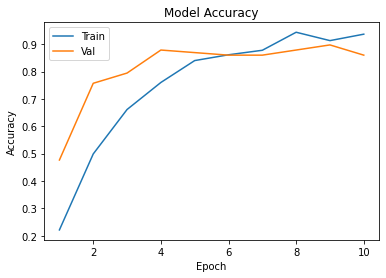

In [63]:
# Plot training and validation accuracy values
# sparse_categorical_accuracy vs val_sparse_categorical_accuracy
plt.plot(epoch_range, history.history["accuracy"])
plt.plot(epoch_range, history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

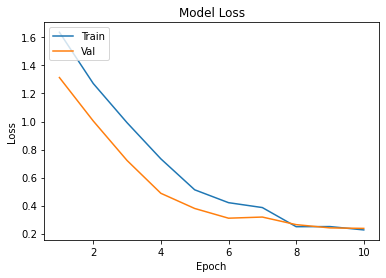

In [64]:
# Plot training and validation loss values
# Loss vs Val_Loss
plt.plot(epoch_range, history.history["loss"])
plt.plot(epoch_range, history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()